In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.interpolate import CloughTocher2DInterpolator

import warnings
warnings.filterwarnings('ignore')

from utils import *

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Helvetica",
        "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}",
    }
)

In [28]:
C = 343.
RHO = 1.2

# C-Shaped Sonic Crystals

## Convergence Analysis for the Number of Elements per Wavelength

### Pressure

In [29]:
data_file = pathlib.Path.cwd().joinpath("data", "c_shape", "convergence_elements_lambda.tar.gz")
data = load_tar(data_file)

In [30]:
frequencies = set()
for dataset in data:
    frequencies.add(dataset.frequencies.item())

df = pd.DataFrame()
for freq in frequencies:
    freq_datasets = []
    n_es = []
    for dataset in data:
        if freq != dataset.frequencies.item():
            continue
        freq_datasets.append(dataset)
        n_es.append(dataset.description.elements_per_lambda)
    n_es_indices = np.argsort(n_es)

    indices = (freq_datasets[n_es_indices[-1]].x[:, 0] <= 9.5 * 22e-3) & (
            freq_datasets[n_es_indices[-1]].x[:, 0] >= -0.5 * 22e-3)
    geometry = freq_datasets[n_es_indices[-1]].x[indices, :2]
    pressure = freq_datasets[n_es_indices[-1]].p[0, indices]

    interp_real = CloughTocher2DInterpolator(geometry, np.real(pressure))
    interp_imag = CloughTocher2DInterpolator(geometry, np.imag(pressure))

    for idx in n_es_indices[:-1]:
        dataset = freq_datasets[idx]

        indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
        geometry = dataset.x[indices, :2]
        pressure = dataset.p[0, indices]

        gt_real = interp_real(geometry[:, 0], geometry[:, 1])
        gt_imag = interp_imag(geometry[:, 0], geometry[:, 1])

        real_diff = np.abs(np.real(pressure) - gt_real) / np.max(np.abs(gt_real))
        imag_diff = np.abs(np.imag(pressure) - gt_imag) / np.max(np.abs(gt_imag))

        real_l1 = np.mean(real_diff)
        imag_l1 = np.mean(imag_diff)

        tmp_df = pd.DataFrame({
            "frequency": [freq] * 2,
            "value": [real_l1, imag_l1],
            "complex": ["real", "imag"],
            "n_e": [dataset.description.elements_per_lambda] * 2
        })
        df = pd.concat([df, tmp_df], ignore_index=True)

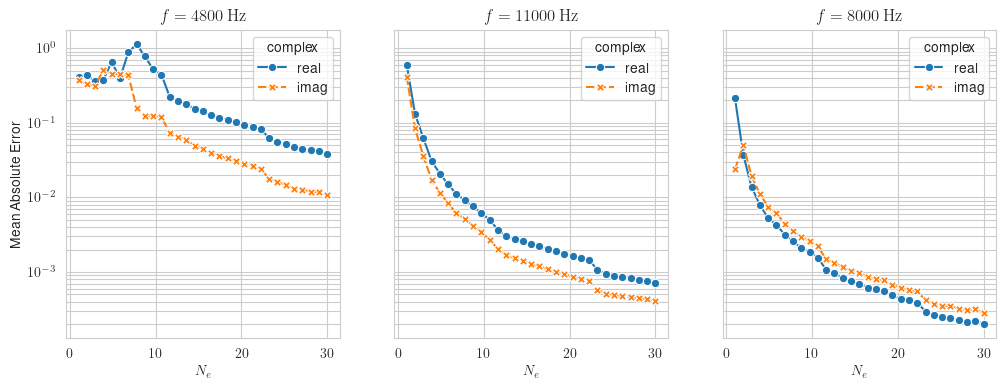

In [31]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)

for i, f in enumerate(df["frequency"].unique()):
    sns.lineplot(df[df["frequency"] == f], x="n_e", y="value", hue="complex", ax=axs[i], color='black', style='complex',
                 markers=True)
    axs[i].title.set_text(f"$f={f:.0f}" + r"\,\si{\hertz}$")

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('$N_e$')
    ax.set_ylabel('Mean Absolute Error')
    ax.xaxis.grid(True)
    ax.yaxis.grid(True, which='both')

### Transmission Loss


In [32]:
data_file = pathlib.Path.cwd().joinpath("data", "c_shape", "convergence_elements_lambda_transmission_loss.tar.gz")
data = load_tar(data_file)

In [33]:
from hsc.eval import transmission_loss
tls = []
n_e = []
diffs = []

for dataset in data:
    n_e.append(dataset.description.elements_per_lambda)

indices = np.argsort(n_e).tolist()
n_e = []

for idx in reversed(indices):
    dataset = data[idx]
    tls.append(transmission_loss(dataset))
    n_e.extend([dataset.description.elements_per_lambda] * len(dataset.frequencies))
    diffs.append(tls[-1] - tls[0]) 
df = pd.DataFrame({
    "Transmission Loss $[\si{\decibel}]$": np.stack(tls).flatten().tolist(),
    "tl_diff": np.stack(diffs).flatten().tolist(),
    "Frequency $[\si{\hertz}]$": data[0].frequencies.tolist() * len(data),
    "$N_e$": n_e
})

Text(0.5, 0, 'Difference $TL_i - TL_{50}$')

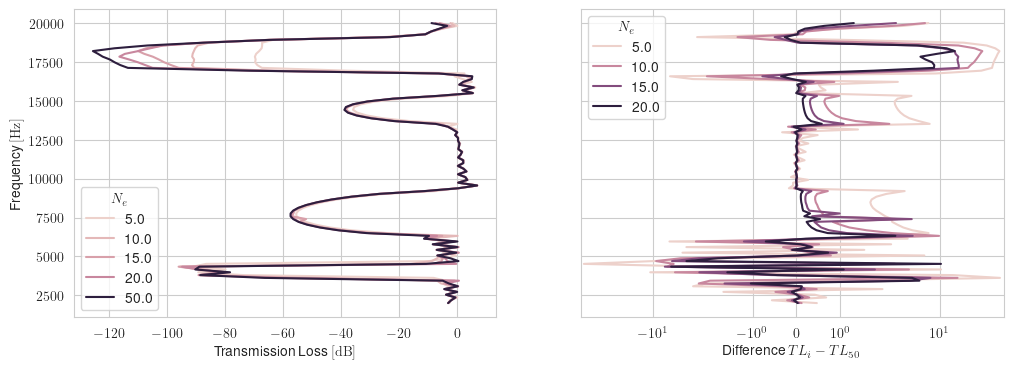

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

sns.lineplot(data=df, x="Transmission Loss $[\si{\decibel}]$", y="Frequency $[\si{\hertz}]$", hue="$N_e$", orient="y", ax=axs[0])
sns.lineplot(data=df[df["$N_e$"] != 50], x="tl_diff", y="Frequency $[\si{\hertz}]$", hue="$N_e$", orient="y", ax=axs[1])
axs[1].set_xscale('symlog')
axs[1].set_xlabel('Difference $TL_i - TL_{50}$')

## Depth of the Absorbers

In [35]:
data_file = pathlib.Path.cwd().joinpath("data", "c_shape", "depth_adiabatic_layer.tar.gz")
data = load_tar(data_file)

In [36]:
from hsc.eval import transmission_loss
tls = []
d_a = []
diffs = []

for dataset in data:
    d_a.append(dataset.description.absorber.depth)

indices = np.argsort(d_a).tolist()
d_a = []

for idx in reversed(indices):
    dataset = data[idx]
    max_wl = 343. / min(dataset.frequencies)
    tls.append(transmission_loss(dataset))
    d_a.extend([dataset.description.absorber.depth / max_wl] * len(dataset.frequencies))
    diffs.append(tls[-1] - tls[0]) 
df = pd.DataFrame({
    "Transmission Loss $[\si{\decibel}]$": np.stack(tls).flatten().tolist(),
    "tl_diff": np.stack(diffs).flatten().tolist(),
    "Frequency $[\si{\hertz}]$": data[0].frequencies.tolist() * len(data),
    "$d_a$": d_a
})
df["abs_tl_diff"] = df["tl_diff"].apply(np.abs)

Text(0.5, 0, 'Difference $TL_i - TL_{50}$')

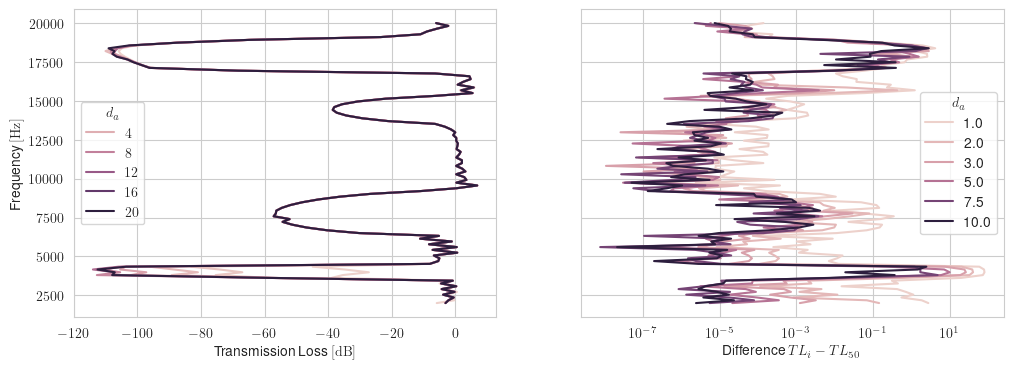

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

sns.lineplot(data=df, x="Transmission Loss $[\si{\decibel}]$", y="Frequency $[\si{\hertz}]$", hue="$d_a$", orient="y", ax=axs[0])
sns.lineplot(data=df[df["$d_a$"] != 20], x="abs_tl_diff", y="Frequency $[\si{\hertz}]$", hue="$d_a$", orient="y", ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_xlabel('Difference $TL_i - TL_{50}$')

## Comparison to COMSOL

### Pressure

In [38]:
data_file = pathlib.Path.cwd().joinpath("data", "c_shape", "crystal.csv")
comsol_dataset = hsc.HelmholtzDataset.from_comsol_file(data_file, data[0].description)

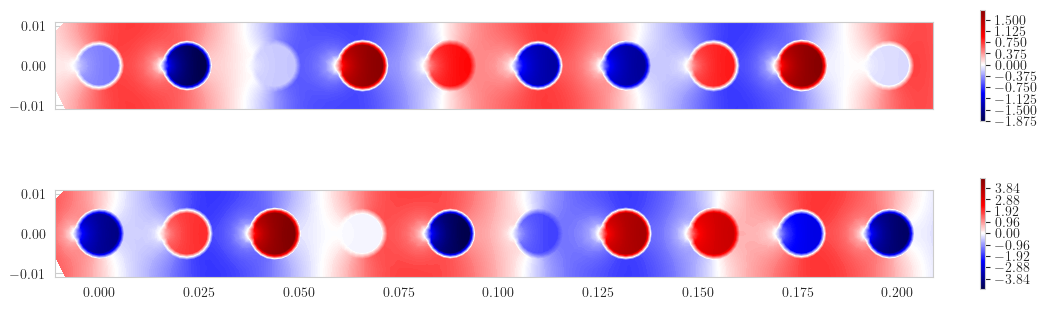

In [39]:
indices = (comsol_dataset.x[:, 0] <= 9.5 * 22e-3) & (comsol_dataset.x[:, 0] >= -0.5 * 22e-3)
idx_4800 = np.where(comsol_dataset.frequencies == 4800) 

fig, axs = plt.subplots(nrows=2, figsize=(12, 4), sharex=True, sharey=True)

v_max = np.max(np.abs(np.real(comsol_dataset.p[idx_4800, indices])))
im = axs[0].tricontourf(comsol_dataset.x[indices, 0], comsol_dataset.x[indices, 1], np.real(comsol_dataset.p[idx_4800, indices]).squeeze(), levels=256, cmap='seismic', vmin=-v_max, vmax=v_max)
fig.colorbar(im, ax=axs[0], fraction=0.006)

v_max = np.max(np.abs(np.imag(comsol_dataset.p[idx_4800, indices])))
im = axs[1].tricontourf(comsol_dataset.x[indices, 0], comsol_dataset.x[indices, 1], np.imag(comsol_dataset.p[idx_4800, indices]).squeeze(), levels=256, cmap='seismic', vmin=-v_max, vmax=v_max)
fig.colorbar(im, ax=axs[1], fraction=0.006)

for ax in axs.flatten():
    ax.set_aspect('equal')

In [40]:
xx, yy = np.meshgrid(
    np.linspace(-.5 * 22e-3, 9.5 * 22e-3, 300),
    np.linspace(-.5 * 22e-3, .5 * 22e-3, 50),
)
new_geo = np.stack([xx.flatten(), yy.flatten()], axis=1)

indices = (comsol_dataset.x[:, 0] <= 9.5 * 22e-3) & (comsol_dataset.x[:, 0] >= -0.5 * 22e-3)
geo = comsol_dataset.x[indices, :2]
pressure = comsol_dataset.p[idx_4800, indices].squeeze()
p_interp = CloughTocher2DInterpolator(geo, np.real(pressure), fill_value=0.)

p_comsol = p_interp(new_geo)

In [41]:
data_file = pathlib.Path.cwd().joinpath("data", "c_shape", "comsol_elements_lambda.tar.gz")
data_file_broad = pathlib.Path.cwd().joinpath("data", "c_shape", "convergence_elements_lambda.tar.gz")
data = load_tar(data_file) + load_tar(data_file_broad)

In [42]:
differences = []
pressures = []
n_e = []

for dataset in data:
    if dataset.frequencies.item() != 4800:
        continue
        
    indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
    geo = dataset.x[indices, :2]
    pressure = dataset.p[0, indices]
    p_interp = CloughTocher2DInterpolator(geo, np.real(pressure), fill_value=0.)
    p_ours = p_interp(new_geo)
    
    differences.append(p_comsol - p_ours)
    n_e.append(dataset.description.elements_per_lambda)
    pressures.append(p_ours)
indices = np.argsort(n_e)

df = pd.DataFrame({
    "n_e": n_e,
    "ms_diff": [np.mean(diff ** 2) for diff in differences],
})

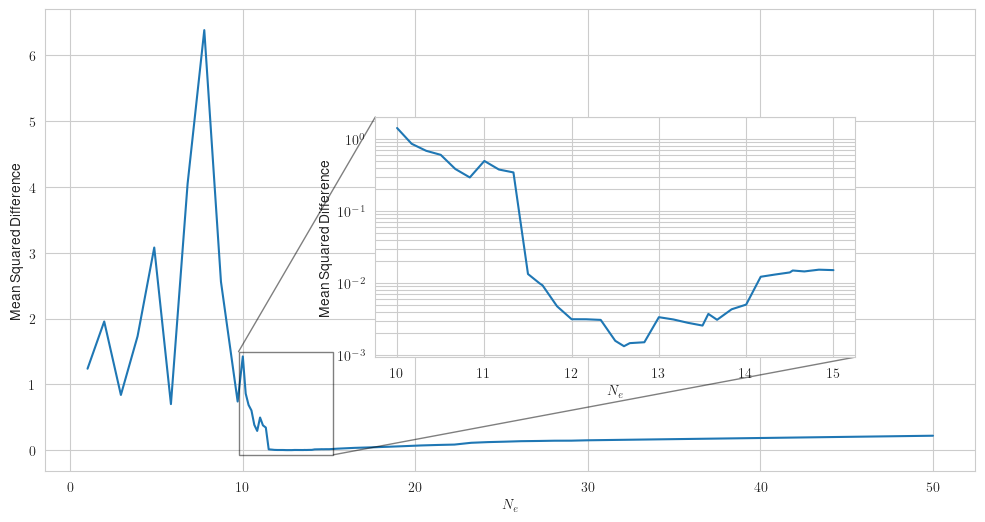

In [43]:
fig, ax = plt.subplots(figsize=(12, 6), sharey=True)

zoom_ax = fig.add_axes([0.4, 0.3, 0.4, 0.4])

sns.lineplot(df, x="n_e", y="ms_diff", ax=ax)
sns.lineplot(df[(df["n_e"] >= 10) & (df["n_e"] <= 15)], x="n_e", y="ms_diff", ax=zoom_ax)
ax.indicate_inset_zoom(zoom_ax, edgecolor="black")

zoom_ax.set_yscale('log')

for axi in [ax, zoom_ax]:
    axi.set_xlabel("$N_e$")
    axi.set_ylabel("Mean Squared Difference")
    axi.yaxis.grid(True, which='both')

In [44]:
print(df[df['ms_diff'] == min(df['ms_diff'])])

     n_e   ms_diff
52  12.6  0.001319


### Transmission loss

In [45]:
data_file = pathlib.Path.cwd().joinpath("data", "c_shape", "convergence_elements_lambda_transmission_loss.tar.gz")
data = load_tar(data_file)
dataset = [dataset for dataset in data if dataset.description.elements_per_lambda == 15][0]

In [46]:
tl_comsol = transmission_loss(comsol_dataset)
tl_ours = transmission_loss(dataset)

Text(0, 0.5, 'Frequency $[\\si{\\hertz}]$')

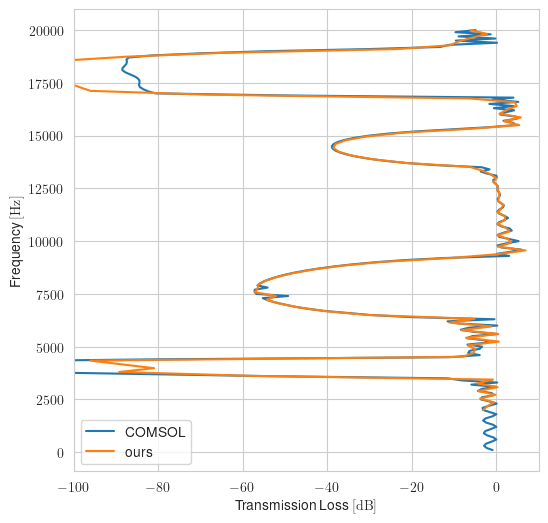

In [47]:
fig, ax = plt.subplots(figsize=(6, 6), sharey=True)

ax.plot(tl_comsol, comsol_dataset.frequencies, label='COMSOL')
ax.plot(tl_ours, dataset.frequencies, label='ours')
ax.legend()
ax.set_xlim(-100, 10)

ax.set_xlabel('Transmission Loss $[\si{\decibel}]$')
ax.set_ylabel('Frequency $[\si{\hertz}]$')


In [48]:
data_file = pathlib.Path.cwd().joinpath("data", "c_shape", "comsol_elements_lambda.tar.gz")
data_file_broad = pathlib.Path.cwd().joinpath("data", "c_shape", "convergence_elements_lambda.tar.gz")
data = load_tar(data_file) + load_tar(data_file_broad)

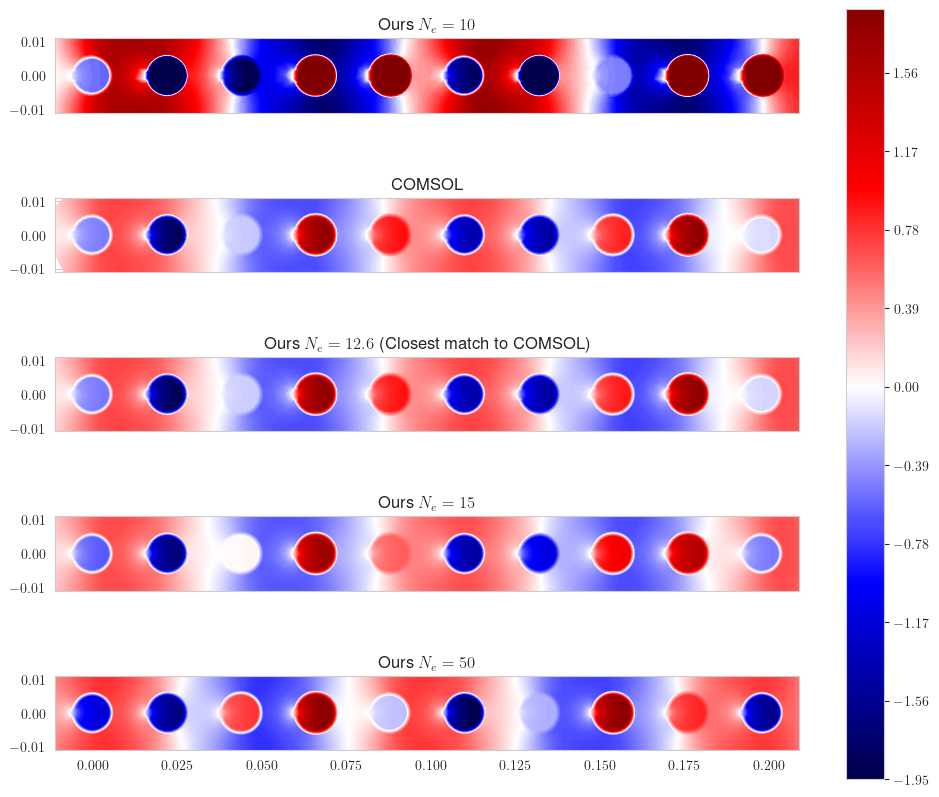

In [49]:
fig, axs = plt.subplots(nrows=5, figsize=(12, 10), sharex=True, sharey=True)

dataset = next(dataset for dataset in data if dataset.description.elements_per_lambda == 50)
indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
v_max = np.max(np.abs(np.real(dataset.p[0, indices])))

dataset = next(dataset for dataset in data if dataset.description.elements_per_lambda == 10)
indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
axs[0].tricontourf(dataset.x[indices, 0], dataset.x[indices, 1], np.real(dataset.p[0, indices]).squeeze(), levels=256, cmap='seismic', vmin=-v_max, vmax=v_max)
axs[0].title.set_text('Ours $N_e=10$')

indices = (comsol_dataset.x[:, 0] <= 9.5 * 22e-3) & (comsol_dataset.x[:, 0] >= -0.5 * 22e-3)
idx_4800 = np.where(comsol_dataset.frequencies == 4800)
axs[1].tricontourf(comsol_dataset.x[indices, 0], comsol_dataset.x[indices, 1], np.real(comsol_dataset.p[idx_4800, indices]).squeeze(), levels=256, cmap='seismic', vmin=-v_max, vmax=v_max)
axs[1].title.set_text('COMSOL')

dataset = next(dataset for dataset in data if dataset.description.elements_per_lambda == 12.6)
indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
axs[2].tricontourf(dataset.x[indices, 0], dataset.x[indices, 1], np.real(dataset.p[0, indices]).squeeze(), levels=256, cmap='seismic', vmin=-v_max, vmax=v_max)
axs[2].title.set_text('Ours $N_e=12.6$ (Closest match to COMSOL)')

dataset = next(dataset for dataset in data if dataset.description.elements_per_lambda == 15)
indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
axs[3].tricontourf(dataset.x[indices, 0], dataset.x[indices, 1], np.real(dataset.p[0, indices]).squeeze(), levels=256, cmap='seismic', vmin=-v_max, vmax=v_max)
axs[3].title.set_text('Ours $N_e=15$')

dataset = next(dataset for dataset in data if dataset.description.elements_per_lambda == 50)
indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
im = axs[4].tricontourf(dataset.x[indices, 0], dataset.x[indices, 1], np.real(dataset.p[0, indices]).squeeze(), levels=256, cmap='seismic', vmin=-v_max, vmax=v_max)
axs[4].title.set_text('Ours $N_e=50$')

fig.colorbar(im, ax=axs)

for ax in axs.flatten():
    ax.set_aspect('equal')